<a href="https://colab.research.google.com/github/Nelson-iitp/2121CS07_CS575/blob/main/Assignment_2/%5BSOLUTION%5D_CS575_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import  ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller, kpss

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# [00] DataSet Load

In [2]:
D1_PATH = "https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_2/D1.csv"
D2_PATH = "https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_2/D2.csv"
D3_PATH = "https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_2/D3.csv"
DS_COLNAMES = np.array(["time","value"])
DS1 = pd.read_csv(D1_PATH, sep=",", header=0, names=DS_COLNAMES)
DS2 = pd.read_csv(D2_PATH, sep=",", header=0, names=DS_COLNAMES)
DS3 = pd.read_csv(D3_PATH, sep=",", header=0, names=DS_COLNAMES)
DSA = [DS1, DS2, DS3]

# [01] Exponential Smoothing

Implement Single, double and triple Exponential Smoothing for all the three datasets as provided. Do not use the built in libraries, use the ones mentioned on the page


Single Exponential Smoothing
https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc431.htm

Double Exponential Smoothing (Single Smoothing does not excel in following the data when there is a trend)
https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc433.htm

Triple Exponential Smoothing (for trend and seasonality)
https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm

Three values for each of alpha, beta, gamma need to be taken. Example, For alpha test the MSE using values between [0.01-0.99] and similary check the affect of different combination of gamma and beta values on the MSE. At least check for 3 values of each alpha, beta, gamma.

PS: Plot the predictions for each interval. Since you will try various values for alpha, beta, gamma, plot only the values for which you get the least MSE. For example if alpha, beta, gamma = 0.3, 0.4, 0.5 gives MSE = 1.5 for 1 hour prediction, and if alpha, beta, gamma = 0.2, 0.7, 0.3 gives MSE = 1.02 for 1 hour prediction, plot the latter one.


## [A] Implementation

In [3]:
data_LA = [12,2,6]
class ExpSmoothingData:
  def __init__(self, y):
    # L = periods in a season, at most half of total duration - so that b(t) can be initialized
    self.y = y
    self.N = len(y)
    #print(type(self.y),type(self.N),self.N)

#~~~ SINGLE 0~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  def Do_Single_ES(self, a):
    N,y=self.N,self.y
    self.S = np.zeros(N,dtype='float')        #Smoothed Value  ::'0th element is invalid'
    S=self.S
    # initialization 
    S[0] = y[0] 
    # Find Smoothed values
    for t in range(1, N):
      S[t] = a*y[t] + (1-a)*S[t-1]

    # calculate the MSE
    MSE = (  np.sum( ( (y[1:]-S[1:])**2 )   )) / (N-1)

    # done
    return MSE, S
#~~~ DOUBLE 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  def Do_Double_ES(self, a, b): 
  # orignal Double ES
    N,y=self.N,self.y
    self.S = np.zeros(N).astype('float')        #Smoothed Value  ::'0th element is invalid'
    self.B = np.zeros(N).astype('float')          #b(t)
    B,S = self.B,self.S

    # initialization 
    S[0],B[0] = y[0], y[1] - y[0]

    # Find Smoothed values
    for t in range(1, N):
      S[t] = a*y[t] + (1-a)*(S[t-1]+B[t-1]) #<--- 1
      B[t] = b*(S[t]-S[t-1]) + (1-b)*B[t-1]

    # calculate the MSE
    MSE = (  np.sum( ( (y[1:]-S[1:])**2 )   )) / (N-1)

    # done
    return MSE, S

  def Do_Forecast_2(self, t, m):
    N,y=self.N,self.y
    S,B=self.S,self.B

    res = np.zeros(m)
    for i in range(1,m+1):
      res[i-1]=(S[t]+i*B[t])
    #res = (S[t]+m*B[t])#*I[t-L+m]

    return res
#~~~ TRIPLE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  def Do_Triple_ES(self, a, b, g, L):
    N,y=self.N,self.y
    # inits
    self.TS = (N/L)                   #total seasons
    self.S = np.zeros(N).astype('float')        #Smoothed Value  ::'0th element is invalid'
    self.B = np.zeros(N).astype('float')          #b(t)
    self.I = np.zeros(N).astype('float')          #I(t) seasoal 
    
    TS,B,S,I = self.TS,self.B,self.S,self.I

    # initialization 
    S[0], B[0] = y[0], 0

    # Intial Trend Factor
    for i in range(0,L):
      B[0]+=y[L+i]-y[i]
    B[0]/=(L**2)
    

    # Initial Seasonal Indices
    yy = np.copy(y).reshape(int(TS),L).astype('float')
    for i in range(0, int(TS)):
      #print(np.average(yy[i,:]))
      #print('iseasonalX:',(np.average(yy[i,:]) ))
      yy[i,:] = yy[i,:]/(np.average(yy[i,:])) 
      
    for i in range(0,L):
      I[i] = np.average(yy[:,i])
      #print('iseasonal_:',I[i] )
      #only first L values available (0 to L-1)

    # Find Smoothed values
    for t in range(1, N):
      Ival = None
      if t<L:
        Ival=I[t]
      else:
        Ival=I[t-L]

      S[t] = a*(y[t]/Ival)+(1-a)*(S[t-1]+B[t-1]) #<<---2
      B[t] = b*(S[t]-S[t-1]) + (1-b)*B[t-1]

      #read i's from init values if not available
      if t>=L:
        I[t] = g*(y[t]/S[t]) + (1-g)*Ival
      
    # calculate the MSE
    MSE = (  np.sum( ( (y[1:]-S[1:])**2 )   )) / (N-1)

    # done
    return MSE, S

  def Do_Forecast_3(self, t, m,L):
    N,y=self.N,self.y
    S,B,I=self.S,self.B,self.I

    res = np.zeros(m)
    for i in range(1,m+1):
      res[i-1]=(S[t]+i*B[t])*I[(t-L+1+m-1)%L]
    #res = (S[t]+m*B[t])#*I[t-L+m]
    return res



### [TEST - single]

Dataset 1
Single Exp Smoothing 
	Try alpha [0.58915378 0.67794821 0.68932614]

Minimum MSE = 20622500.16214431 
	 alpha = 0.6893261392566364 



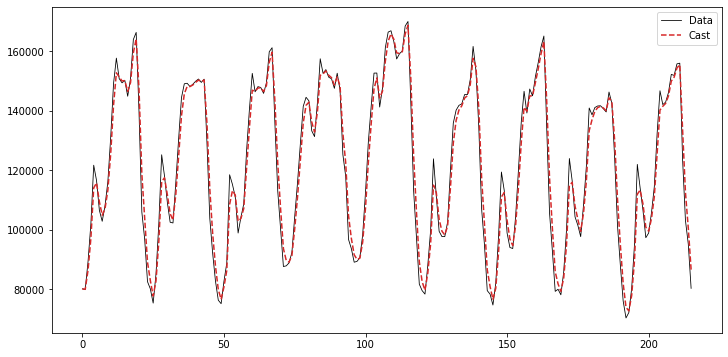

Dataset 2
Single Exp Smoothing 
	Try alpha [0.06099158 0.83008324 0.35081024]

Minimum MSE = 272.6918248945677 
	 alpha = 0.8300832441586757 



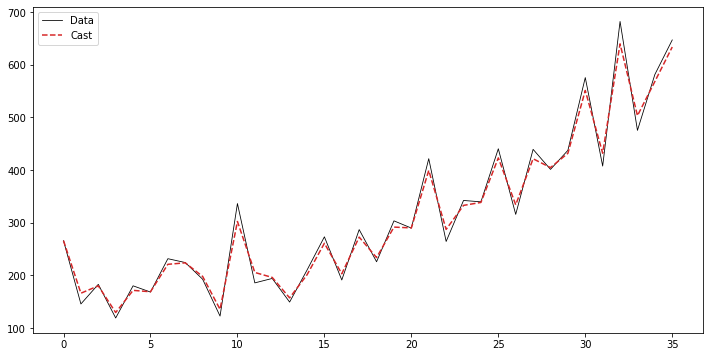

Dataset 3
Single Exp Smoothing 
	Try alpha [0.17579374 0.69738027 0.58130079]

Minimum MSE = 131.55277919066128 
	 alpha = 0.6973802668485412 



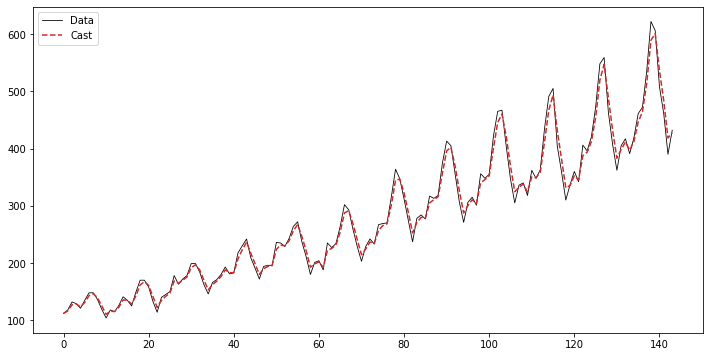

In [4]:
# 1-single exp smoothing
def perform_singleES(es_data, alpha_array):
  print('Single Exp Smoothing','\n\tTry alpha',alpha_array)
  _mse, _cast = [], []
  for alpha in alpha_array:
    mse,cast = es_data.Do_Single_ES(alpha)
    _mse.append(mse)
    _cast.append(cast)

  #  plt.figure(figsize=(12,6))
  #  plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
  #  plt.plot(cast, linestyle='dashed', label="Cast", color='tab:red')
  #  plt.legend()


  # plot minimum mse
  mi = np.argmin(_mse)
  print('\nMinimum MSE =',_mse[mi],"\n\t",'alpha =',alpha_array[mi],'\n' )
  plt.figure(figsize=(12,6))
  plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
  plt.plot(_cast[mi], linestyle='dashed', label="Cast", color='tab:red')
  plt.legend()
  plt.show()
  return _mse[mi], _cast[mi]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for i in range(0, len(DSA)):
  print('Dataset',i+1)
  es_data = ExpSmoothingData(np.array(DSA[i]['value'])) # orignal data
  perform_singleES(
      es_data, 
      np.random.rand(3) 
      )


### [TEST - double]

Dataset 1
Double Exp Smoothing 
	Try alpha [0.73356763 0.71950018 0.01802399] 
	Try beta [0.74764011 0.27032712 0.43716786]

Minimum MSE: 13042197.640763652 
	 alpha = 0.733567631214409 
	 beta = 0.7476401077150898 



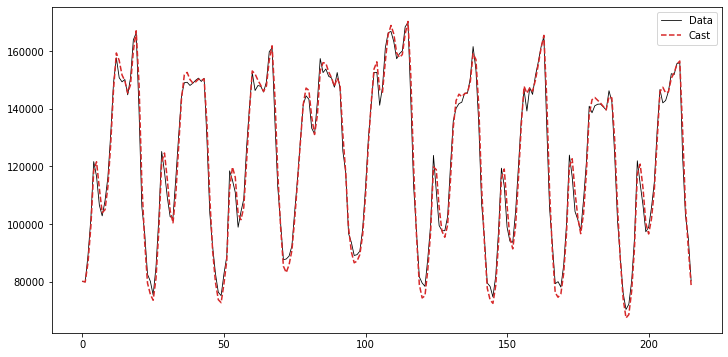

Dataset 2
Double Exp Smoothing 
	Try alpha [0.46170416 0.93348801 0.9001629 ] 
	Try beta [0.42680271 0.93680567 0.49485923]

Minimum MSE: 122.75876396076193 
	 alpha = 0.9334880130285002 
	 beta = 0.9368056656597972 



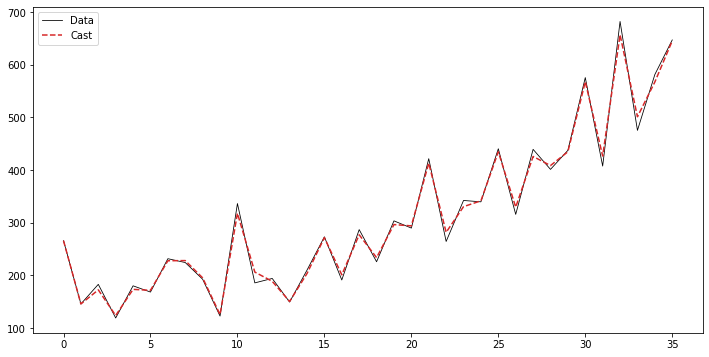

Dataset 3
Double Exp Smoothing 
	Try alpha [0.52682324 0.43242303 0.71977275] 
	Try beta [0.86837263 0.664342   0.36094459]

Minimum MSE: 140.67496549552416 
	 alpha = 0.7197727482491906 
	 beta = 0.36094459104737264 



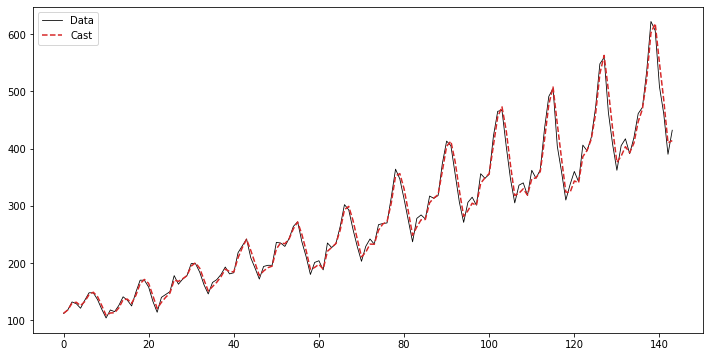

In [5]:
# 2-DOUBLE EXP SMOOTHING 

def perform_DoubleES(es_data, alpha_array,beta_array):
  print('Double Exp Smoothing','\n\tTry alpha',alpha_array, '\n\tTry beta',beta_array)
  _mse, _cast = [], []
  for alpha, beta in zip(alpha_array,beta_array):
    mse,cast = es_data.Do_Double_ES(alpha, beta)
    _mse.append(mse)
    _cast.append(cast)

    #plt.figure(figsize=(12,6))
    #plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
    #plt.plot(cast, linestyle='dashed', label="Cast", color='tab:red')
    #plt.legend()

  # plot minimum mse
  mi = np.argmin(_mse)
  print('\nMinimum MSE:',_mse[mi],"\n\t",'alpha =',alpha_array[mi],'\n\t','beta =',beta_array[mi],'\n' )

  plt.figure(figsize=(12,6))
  plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
  plt.plot(_cast[mi], linestyle='dashed', label="Cast", color='tab:red')
  plt.legend()
  plt.show()
  return _mse[mi], _cast[mi]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for i in range(0, len(DSA)):
  print('Dataset',i+1)
  es_data = ExpSmoothingData(np.array(DSA[i]['value'])) # orignal data
  perform_DoubleES(
      es_data, 
      np.random.rand(3),
      np.random.rand(3) 
      )


### [TEST - triple]

Dataset 1
Triple Exp Smoothing 
	Try alpha [0.087017   0.62247164 0.78714542] 
	Try beta [0.8385579  0.51343862 0.9626598 ] 
	Try gamma [0.52211402 0.10647576 0.80551492]

Minimum MSE: 113122655.69005637 
	 alpha = 0.6224716443343006 
	 beta = 0.5134386223164583 
	 gamma = 0.10647576254075619 



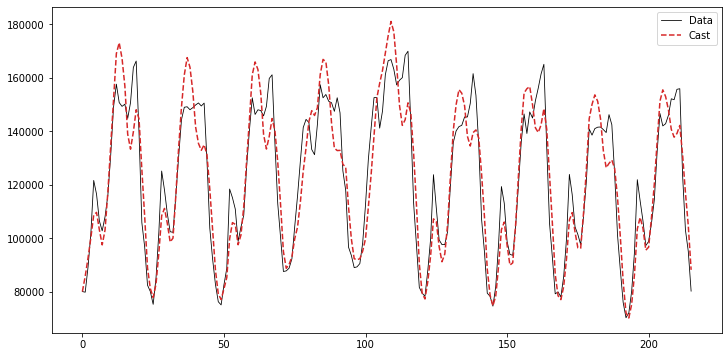

Dataset 2
Triple Exp Smoothing 
	Try alpha [0.06541659 0.19827384 0.08822047] 
	Try beta [0.68162974 0.84456893 0.85053039] 
	Try gamma [0.13620326 0.70649505 0.05641398]

Minimum MSE: 10095.005883653814 
	 alpha = 0.08822047240512954 
	 beta = 0.850530394391036 
	 gamma = 0.0564139835928118 



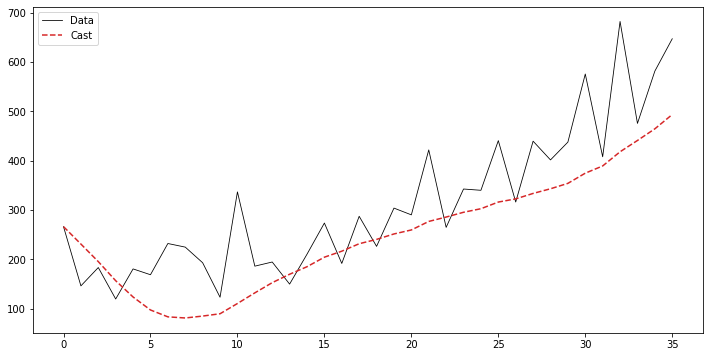

Dataset 3
Triple Exp Smoothing 
	Try alpha [0.37403651 0.0692486  0.77340535] 
	Try beta [0.28810667 0.40031517 0.97251187] 
	Try gamma [0.5105287  0.84728332 0.48062134]

Minimum MSE: 524.7087996671214 
	 alpha = 0.7734053496272401 
	 beta = 0.9725118670342815 
	 gamma = 0.48062133540114305 



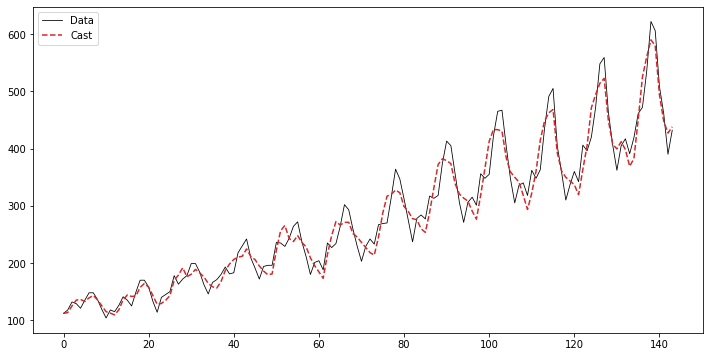

In [6]:
# 3-TRIPLE EXP SMOOTHING 

def perform_TripleES(es_data, alpha_array,beta_array,gamma_array, data_L):
  print('Triple Exp Smoothing','\n\tTry alpha',alpha_array, '\n\tTry beta',beta_array, '\n\tTry gamma',gamma_array)
  _mse, _cast = [], []
  for alpha, beta, gamma in zip(alpha_array,beta_array,gamma_array):
    mse,cast = es_data.Do_Triple_ES(alpha, beta, gamma, data_L)
    _mse.append(mse)
    _cast.append(cast)

    #plt.figure(figsize=(12,6))
    #plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
    #plt.plot(cast, linestyle='dashed', label="Cast", color='tab:red')
    #plt.legend()

  # plot minimum mse
  mi = np.argmin(_mse)
  print('\nMinimum MSE:',_mse[mi],"\n\t",'alpha =',alpha_array[mi],'\n\t','beta =',beta_array[mi],'\n\t','gamma =',gamma_array[mi],'\n' )

  plt.figure(figsize=(12,6))
  plt.plot(es_data.y, linewidth="0.8", label="Data", color="black")
  plt.plot(_cast[mi], linestyle='dashed', label="Cast", color='tab:red')
  plt.legend()
  plt.show()
  return _mse[mi], _cast[mi]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(0, len(DSA)):
  print('Dataset',i+1)
  es_data = ExpSmoothingData(np.array(DSA[i]['value'])) # orignal data
  perform_TripleES(
      es_data, 
      np.random.rand(3),
      np.random.rand(3),
      np.random.rand(3),
      data_LA[i]
      )



# [02] ADF and KPSS TEST

In [7]:
# define adf and kpss testing

def adf_test(ds):
    timeseries = ds.dropna()
    print ('\nDickey-Fuller Test Hypothesis: Process is Non-Stationary ')
    dftest = adfuller(timeseries,  regression='c', autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = (value, "Hypothesis:"+str((dfoutput[0]>value)))
    print(dfoutput)

def kpss_test(ds):
    timeseries = ds.dropna()
    print ('\nKPSS Test Hypothesis: Process is Trend-Stationary',)
    kpsstest = kpss(timeseries, regression='ct')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = (value, "Hypothesis:"+str((kpsstest[0]<=value)))
    print (kpss_output)



## Dataset 1 (D1)

Dataset 1 (D1):
ADS - Hourly Data

Compute the KPSS and ADF test and comment on the stationariety of the Dataset D1

Predict values for the following intervals

**1 hour,
2 hour,
4 hour,
8 hour,
12 hour,
24 hour,
48 hour**

Make a table of the above intervals and report the least MSE for each of the interval.

Plot the MSE for the constructed table.

### [1] Compute the KPSS and ADF test and comment on the stationariety of the Dataset D1


Dickey-Fuller Test Hypothesis: Process is Non-Stationary 
Test Statistic                                                -7.08963
p-value                                                     4.4448e-10
#Lags Used                                                           9
Number of Observations Used                                        206
Critical Value (1%)            (-3.4624988216864776, Hypothesis:False)
Critical Value (5%)            (-2.8756749365852587, Hypothesis:False)
Critical Value (10%)           (-2.5743041549627677, Hypothesis:False)
dtype: object

KPSS Test Hypothesis: Process is Trend-Stationary
Test Statistic                          0.0644264
p-value                                       0.1
Lags Used                                      15
Critical Value (10%)     (0.119, Hypothesis:True)
Critical Value (5%)      (0.146, Hypothesis:True)
Critical Value (2.5%)    (0.176, Hypothesis:True)
Critical Value (1%)      (0.216, Hypothesis:True)
dtype: object


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


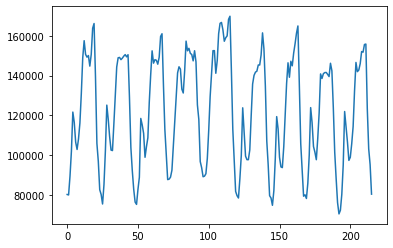

In [8]:
# ANSWER: Process is Sationary

data = DS1['value']
adf_test(data)
kpss_test(data)
plt.plot(data)

### [2] Predict values for the following intervals

1 hour, 2 hour, 4 hour, 8 hour, 12 hour, 24 hour, 48 hour

Make a table of the above intervals and report the least MSE for each of the interval.

Plot the MSE for the constructed table.

Dataset 1
Interval = 1 MSE = 886798.8899999945


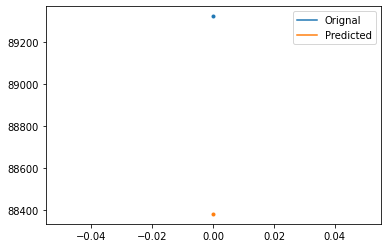

Interval = 2 MSE = 1360964.849449995


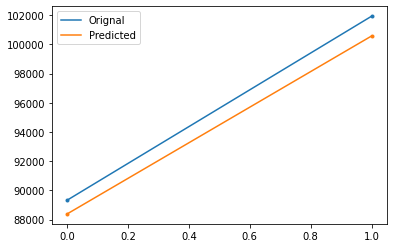

Interval = 4 MSE = 1811979.3755424733


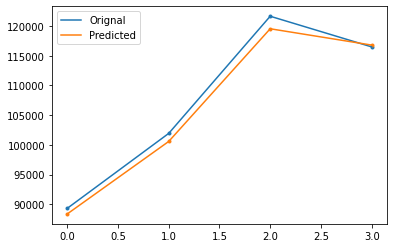

Interval = 8 MSE = 1186160.026536719


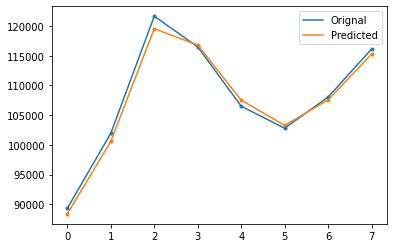

Interval = 12 MSE = 1437365.2911040336


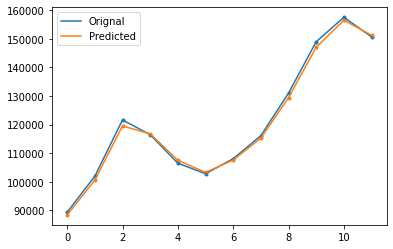

Interval = 24 MSE = 1850808.6843481476


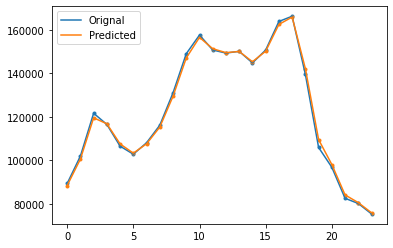

Interval = 48 MSE = 1655229.1419755241


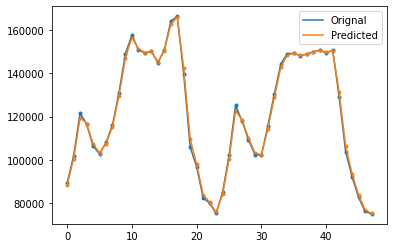

MSEs


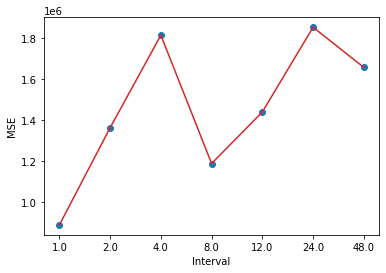

In [9]:
# predicted values/ smoothed values are already computed 
# extract interval data
# 216 hrs = 9 x 24 hrs
print('Dataset 1')

es_data = ExpSmoothingData(np.array(DS1['value'])) # orignal data
mse,cast = es_data.Do_Single_ES(0.9)

intervals = [1,2,4,8,12,24,48]
mses = []
for i in intervals:
  # take a random location of interval = i
  iarr = cast[2:i+2]
  imse = np.sum((es_data.y[2:i+2] - cast[2:i+2])**2)/i
  mses.append([i,imse])
  plt.figure(i)
  print('Interval =',i,'MSE =', imse)
  plt.plot(es_data.y[2:i+2], label="Orignal")
  plt.scatter(np.arange(i),es_data.y[2:i+2], marker=".")
  plt.plot(iarr, label="Predicted")
  plt.scatter(np.arange(i),iarr, marker=".")
  plt.legend()
  plt.show()

_mses = np.array(mses)
print('MSEs')
plt.xticks(np.arange(len(_mses[:,0])), _mses[:,0])
plt.xlabel('Interval')
plt.ylabel('MSE')
plt.scatter(np.arange(len(_mses[:,0])),_mses[:,1], label='mse')
plt.plot(_mses[:,1], color='tab:red')
plt.show()

## Dataset 2 (D2)

Dataset 2 (D2):

Compute the KPSS and ADF test and comment on the stationariety of the Dataset D2

Predict values for the following intervals

**1 month,
2 months,
4 months,
8 months,
12 months,
24 months**

Make a table of the above intervals and report the least MSE for each of the interval.

Plot the MSE for the constructed table.

### [1] Compute the KPSS and ADF test and comment on the stationariety of the Dataset D2


Dickey-Fuller Test Hypothesis: Process is Non-Stationary 
Test Statistic                                                3.06014
p-value                                                             1
#Lags Used                                                         10
Number of Observations Used                                        25
Critical Value (1%)            (-3.7238633119999998, Hypothesis:True)
Critical Value (5%)                    (-2.98648896, Hypothesis:True)
Critical Value (10%)                    (-2.6328004, Hypothesis:True)
dtype: object

KPSS Test Hypothesis: Process is Trend-Stationary
Test Statistic                            0.152649
p-value                                  0.0444593
Lags Used                                       10
Critical Value (10%)     (0.119, Hypothesis:False)
Critical Value (5%)      (0.146, Hypothesis:False)
Critical Value (2.5%)     (0.176, Hypothesis:True)
Critical Value (1%)       (0.216, Hypothesis:True)
dtype: object


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


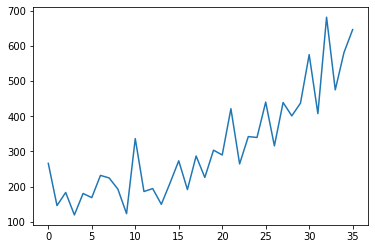

In [10]:
# ANSWER: Process is Non-Sationary

data = DS2['value']
adf_test(data)
kpss_test(data)
plt.plot(data)

### [2] Predict values for the following intervals

1 month, 2 months, 4 months, 8 months, 12 months, 24 months

Make a table of the above intervals and report the least MSE for each of the interval.

Plot the MSE for the constructed table.

### >predict usning double smoothing

Dataset 2
Interval = 1 MSE = 247.43289999999968


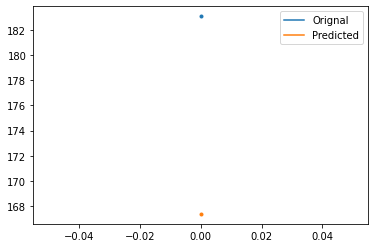

Interval = 2 MSE = 127.38010380499985


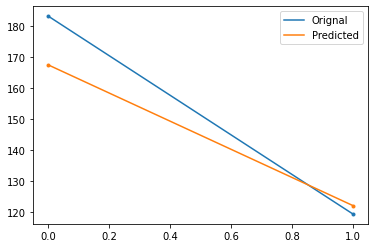

Interval = 4 MSE = 88.43599577243349


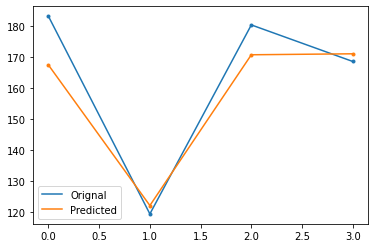

Interval = 8 MSE = 57.35852821427433


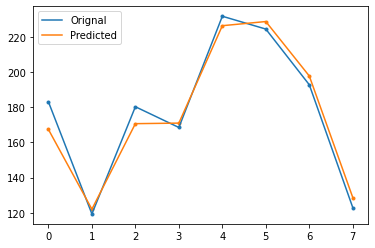

Interval = 12 MSE = 142.18688121966633


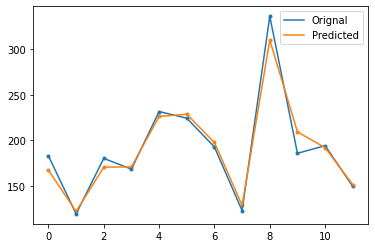

Interval = 24 MSE = 131.9145488541969


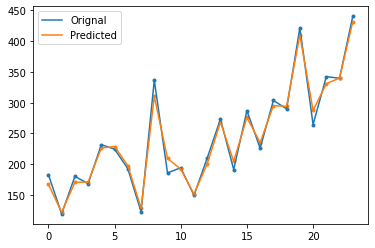

MSEs


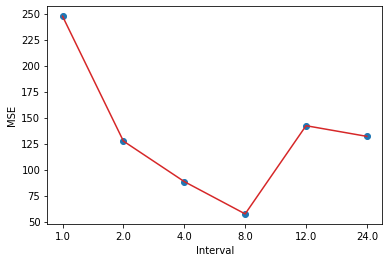

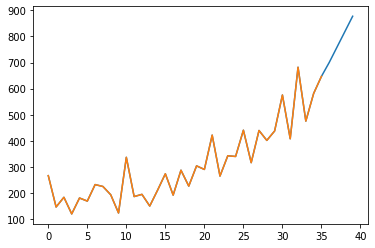

In [14]:
# predicted values/ smoothed values are already computed 
# extract interval data
# 216 hrs = 9 x 24 hrs
print('Dataset 2')

es_data = ExpSmoothingData(np.array(DS2['value'])) # orignal data
mse,cast = es_data.Do_Double_ES(0.9, 0.7)

intervals = [1,2,4,8,12,24]
mses = []
for i in intervals:
  # take a random location of interval = i
  iarr = cast[2:i+2]
  imse = np.sum((es_data.y[2:i+2] - cast[2:i+2])**2)/i
  mses.append([i,imse])
  plt.figure(i)
  print('Interval =',i,'MSE =', imse)
  plt.plot(es_data.y[2:i+2], label="Orignal")
  plt.scatter(np.arange( i),es_data.y[2:i+2], marker=".")
  plt.plot(iarr, label="Predicted")
  plt.scatter(np.arange(i),iarr, marker=".")
  plt.legend()
  plt.show()

_mses = np.array(mses)
print('MSEs')
plt.xticks(np.arange(len(_mses[:,0])), _mses[:,0])
plt.xlabel('Interval')
plt.ylabel('MSE')
plt.scatter(np.arange(len(_mses[:,0])),_mses[:,1], label='mse')
plt.plot(_mses[:,1], color='tab:red')
plt.show()

#forecast
fplt = np.hstack((es_data.y, es_data.Do_Forecast_2(es_data.N-1, data_LA[1]*2) ))
plt.plot(fplt,label='forecast')
plt.plot(es_data.y)
plt.show()

### >predict usning Triple smoothing

Dataset 2
Interval = 1 MSE = 200.66825851943494


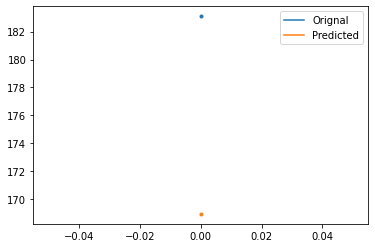

Interval = 2 MSE = 115.06069179191488


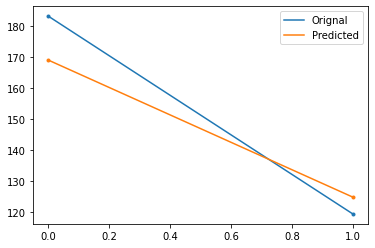

Interval = 4 MSE = 123.95999476530974


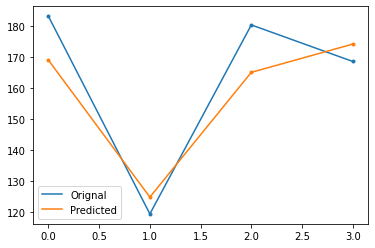

Interval = 8 MSE = 110.25334480742404


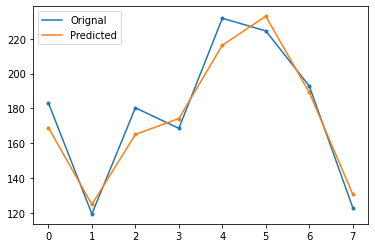

Interval = 12 MSE = 289.91913294614193


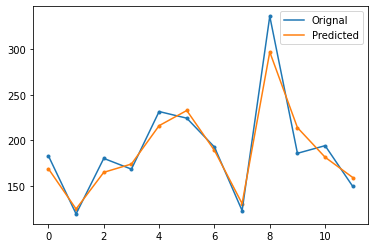

Interval = 24 MSE = 184.9578670964951


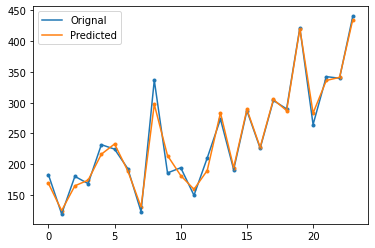

MSEs


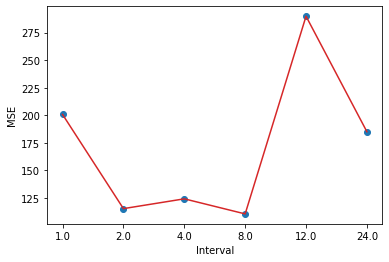

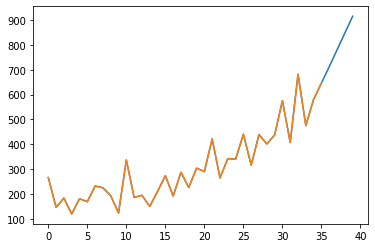

In [19]:
# predicted values/ smoothed values are already computed 
# extract interval data
# 216 hrs = 9 x 24 hrs
print('Dataset 2')

es_data = ExpSmoothingData(np.array(DS2['value'])) # orignal data
mse,cast = es_data.Do_Triple_ES(0.9, 0.7, 0.3,data_LA[1])

intervals = [1,2,4,8,12,24]
mses = []
for i in intervals:
  # take a random location of interval = i
  iarr = cast[2:i+2]
  imse = np.sum((es_data.y[2:i+2] - cast[2:i+2])**2)/i
  mses.append([i,imse])
  plt.figure(i)
  print('Interval =',i,'MSE =', imse)
  plt.plot(es_data.y[2:i+2], label="Orignal")
  plt.scatter(np.arange( i),es_data.y[2:i+2], marker=".")
  plt.plot(iarr, label="Predicted")
  plt.scatter(np.arange(i),iarr, marker=".")
  plt.legend()
  plt.show()

_mses = np.array(mses)
print('MSEs')
plt.xticks(np.arange(len(_mses[:,0])), _mses[:,0])
plt.xlabel('Interval')
plt.ylabel('MSE')
plt.scatter(np.arange(len(_mses[:,0])),_mses[:,1], label='mse')
plt.plot(_mses[:,1], color='tab:red')
plt.show()

#forecast
fplt = np.hstack((es_data.y, es_data.Do_Forecast_3(es_data.N-1, data_LA[1]*2, data_LA[1])))
plt.plot(fplt,label='forecast')
plt.plot(es_data.y)
plt.show()

## Dataset 3 (D3)

Dataset 3 (D3):

Convert to proper date time format and plot the original data. Compute the KPSS and ADF test and comment on the stationariety of the Dataset D3

Predict values for the following intervals for airline-passengers.csv. Compute seasonality index for each month (Arrange data in a matrix of 12 months and years and compute)

**1 month,
2 months,
4 months,
8 months,
12 months,
24 months**

Make a table of the above intervals and report the least MSE for each of the interval.
Plot the MSE for the constructed table.

Also for D3, predict the futuristic 24 months i.e., from 1961-01 till 1962-12 and plot the complete data.

### [1] Convert to proper date time format and plot the original data.

        time  value         DT
0    1949-01    112 1949-01-01
1    1949-02    118 1949-02-01
2    1949-03    132 1949-03-01
3    1949-04    129 1949-04-01
4    1949-05    121 1949-05-01
..       ...    ...        ...
139  1960-08    606 1960-08-01
140  1960-09    508 1960-09-01
141  1960-10    461 1960-10-01
142  1960-11    390 1960-11-01
143  1960-12    432 1960-12-01

[144 rows x 3 columns]


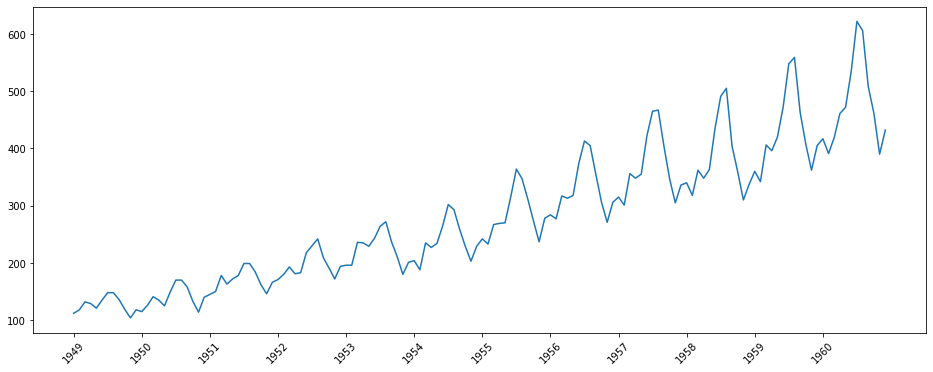

In [20]:
DS3['DT'] =  pd.to_datetime(DS3['time'], format='%Y-%m')
print(DS3)
#DS3['value'].plot()
#plt.scatter( DS3['DT'],DS3['value'], marker='.')
N3 = len(DS3['time'])
plt.figure(figsize=(16,6))
plt.xticks(np.arange( 0,N3,12), [ DS3['time'][x].split("-")[0] for x in range(0, N3, 12) ] ,rotation=45)
plt.plot(DS3['value'])


### [2] Compute the KPSS and ADF test and comment on the stationariety of the Dataset D3


Dickey-Fuller Test Hypothesis: Process is Non-Stationary 
Test Statistic                                               0.815369
p-value                                                       0.99188
#Lags Used                                                         13
Number of Observations Used                                       130
Critical Value (1%)            (-3.4816817173418295, Hypothesis:True)
Critical Value (5%)            (-2.8840418343195267, Hypothesis:True)
Critical Value (10%)            (-2.578770059171598, Hypothesis:True)
dtype: object

KPSS Test Hypothesis: Process is Trend-Stationary
Test Statistic                            0.162737
p-value                                  0.0360529
Lags Used                                       14
Critical Value (10%)     (0.119, Hypothesis:False)
Critical Value (5%)      (0.146, Hypothesis:False)
Critical Value (2.5%)     (0.176, Hypothesis:True)
Critical Value (1%)       (0.216, Hypothesis:True)
dtype: object


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


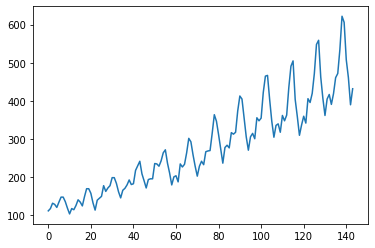

In [21]:
# ANSWER: Process is Non-Sationary

data = DS3['value']
adf_test(data)
kpss_test(data)
plt.plot(data)

### [3] Predict values for the following intervals

Predict values for the following intervals for airline-passengers.csv. Compute seasonality index for each month (Arrange data in a matrix of 12 months and years and compute)

1 month, 2 months, 4 months, 8 months, 12 months, 24 months

Make a table of the above intervals and report the least MSE for each of the interval. Plot the MSE for the constructed table.


### predict using double smoothing

Dataset 3
Interval = 1 MSE = 0.6400000000000182


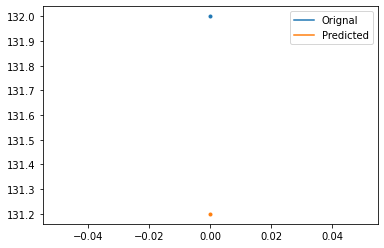

Interval = 2 MSE = 1.1964880000000253


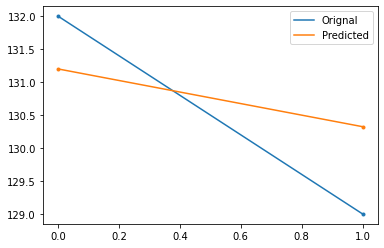

Interval = 4 MSE = 1.7404757179616508


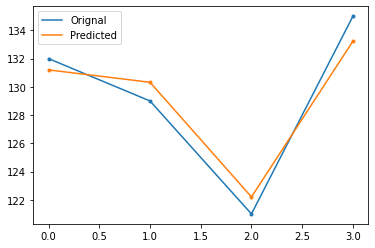

Interval = 8 MSE = 1.697125923406904


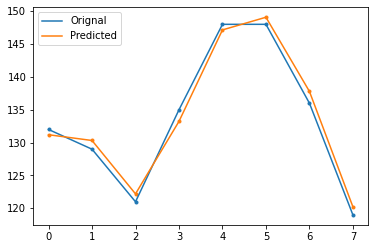

Interval = 12 MSE = 1.934885713141113


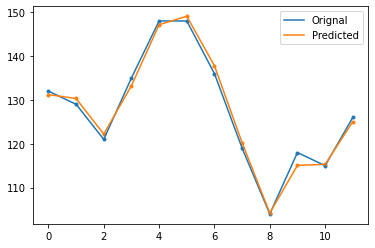

Interval = 24 MSE = 3.059039045868649


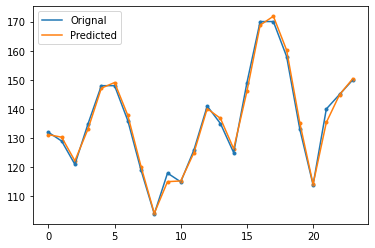

MSEs


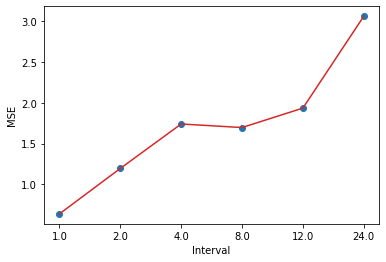

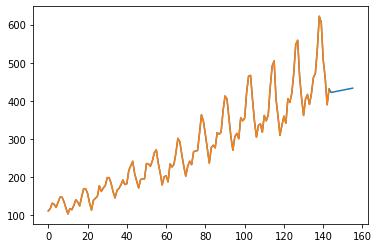

In [22]:
# predicted values/ smoothed values are already computed 
# extract interval data
# 216 hrs = 9 x 24 hrs
print('Dataset 3')

es_data = ExpSmoothingData(np.array(DS3['value'])) # orignal data
mse,cast = es_data.Do_Double_ES(0.9, 0.7)

intervals = [1,2,4,8,12,24]
mses = []
for i in intervals:
  # take a random location of interval = i
  iarr = cast[2:i+2]
  imse = np.sum((es_data.y[2:i+2] - cast[2:i+2])**2)/i
  mses.append([i,imse])
  plt.figure(i)
  print('Interval =',i,'MSE =', imse)
  plt.plot(es_data.y[2:i+2], label="Orignal")
  plt.scatter(np.arange( i),es_data.y[2:i+2], marker=".")
  plt.plot(iarr, label="Predicted")
  plt.scatter(np.arange(i),iarr, marker=".")
  plt.legend()
  plt.show()

_mses = np.array(mses)
print('MSEs')
plt.xticks(np.arange(len(_mses[:,0])), _mses[:,0])
plt.xlabel('Interval')
plt.ylabel('MSE')
plt.scatter(np.arange(len(_mses[:,0])),_mses[:,1], label='mse')
plt.plot(_mses[:,1], color='tab:red')
plt.show()

#forecast
fplt = np.hstack((es_data.y, es_data.Do_Forecast_2(es_data.N-1,data_LA[2]*2)))
plt.plot(fplt,label='forecast')
plt.plot(es_data.y)
plt.show()

### >predict using triple smoothing

Dataset 3
Interval = 1 MSE = 26.839090531332353


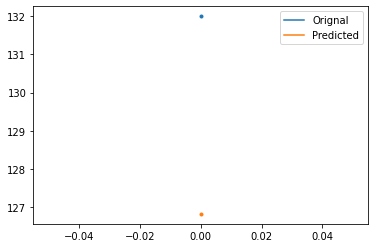

Interval = 2 MSE = 31.137193941612985


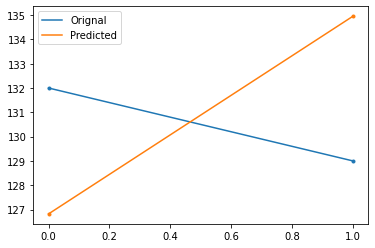

Interval = 4 MSE = 65.54917371992109


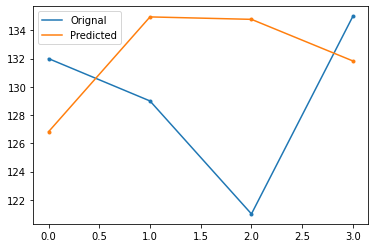

Interval = 8 MSE = 47.044550995936206


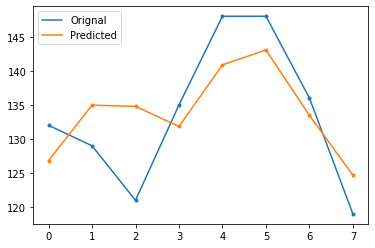

Interval = 12 MSE = 48.210371297435415


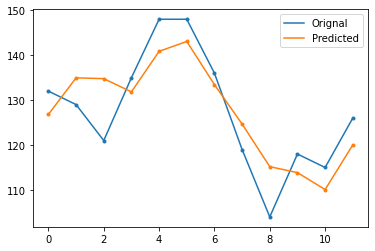

Interval = 24 MSE = 55.931785606715266


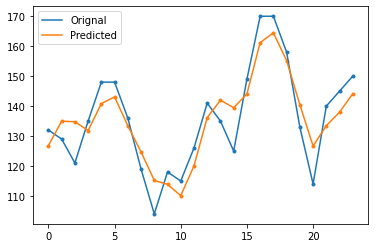

MSEs


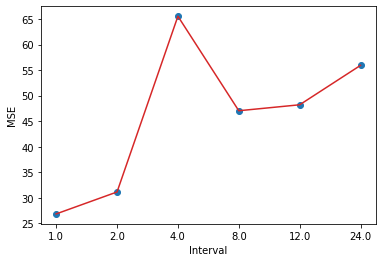

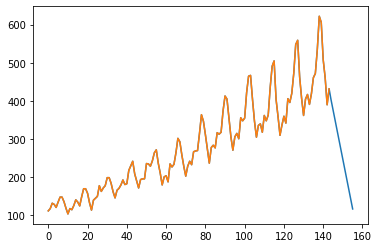

In [23]:
# predicted values/ smoothed values are already computed 
# extract interval data
# 216 hrs = 9 x 24 hrs
print('Dataset 3')

es_data = ExpSmoothingData(np.array(DS3['value'])) # orignal data
mse,cast = es_data.Do_Triple_ES(0.9, 0.7, 0.3,data_LA[2])

intervals = [1,2,4,8,12,24]
mses = []
for i in intervals:
  # take a random location of interval = i
  iarr = cast[2:i+2]
  imse = np.sum((es_data.y[2:i+2] - cast[2:i+2])**2)/i
  mses.append([i,imse])
  plt.figure(i)
  print('Interval =',i,'MSE =', imse)
  plt.plot(es_data.y[2:i+2], label="Orignal")
  plt.scatter(np.arange( i),es_data.y[2:i+2], marker=".")
  plt.plot(iarr, label="Predicted")
  plt.scatter(np.arange(i),iarr, marker=".")
  plt.legend()
  plt.show()

_mses = np.array(mses)
print('MSEs')
plt.xticks(np.arange(len(_mses[:,0])), _mses[:,0])
plt.xlabel('Interval')
plt.ylabel('MSE')
plt.scatter(np.arange(len(_mses[:,0])),_mses[:,1], label='mse')
plt.plot(_mses[:,1], color='tab:red')
plt.show()

#forecast
fplt = np.hstack((es_data.y, es_data.Do_Forecast_3(es_data.N-1,data_LA[2]*2,data_LA[2])))
plt.plot(fplt,label='forecast')
plt.plot(es_data.y)
plt.show()

# [03] compare the errors difference with your implementation

After computing the above three dataset with Single, double and triple Exponential Smoothing; now you know the optimal values of alpha, beta, gamma. Use these values of alpha, beta, gamma and use the inbuilt functions provided and compare the errors difference with your implementation. 

# [Clipboard]

In [ ]:
#fit1 = SimpleExpSmoothing(es_data.y).fit(smoothing_level=alpha,optimized=False)
#plt.plot(fit1.fittedvalues, linestyle='dotted',label="Inbuilt", color='tab:blue' )

#print(len(es_data.y),len(cast),len(fit1.fittedvalues))
#fit1 = ExponentialSmoothing(es_data.y).fit(smoothing_level=alpha, smoothing_slope =beta, optimized=False )
#plt.plot(fit1.fittedvalues, linestyle='dotted',label="Inbuilt", color='tab:blue' )

#fit1 = ExponentialSmoothing(es_data.y,seasonal_periods=data_L).fit( smoothing_level=alpha, smoothing_slope =beta,smoothing_seasonal=gamma, optimized=False )
#plt.plot(fit1.fittedvalues, linestyle='dotted',label="Inbuilt", color='tab:blue' )

In [ ]:
# found on blog
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    #print('iTrend_:',sum / slen )
    return sum / slen
def initial_seasonal_components(series, slen):
  seasonals = {}
  season_averages = []
  n_seasons = int(len(series)/slen)
  # compute season averages
  for j in range(n_seasons):
      season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
  # compute initial values
  for i in range(slen):
      sum_of_vals_over_avg = 0.0
      for j in range(n_seasons):
          sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
      seasonals[i] = sum_of_vals_over_avg/n_seasons
  print('iseasonal_:',seasonals )
  return seasonals
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return np.array(result)